In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sci-kit learn tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit

In [8]:
df = pd.read_csv("data/diabetic_data.csv")

### Introduction

This dataset is from Virginia Commonwealth University and contains medical data for 101766 diabetes-related patients across 130 U.S. hospitals from 1999 to 2008. There are 49 features which include demographic, medical history, laboratory test, and medication prescription data. The response variable is whether or not the patient was readmitted to the hospital.

In [104]:
(df.columns.values)

array(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'], dtype=object)

In [11]:
df.groupby('readmitted')['encounter_id'].nunique()

readmitted
<30    11357
>30    35545
NO     54864
Name: encounter_id, dtype: int64

### Defining X (predictors) and y (response)

In [105]:
y = df['readmitted']
X = df.loc[:, df.columns != 'readmitted']

### Data Cleaning

* Part 1: Replacing 'questions marks' with NaN in the dataset.
* Part 2: Converting yes/no columns to binary.
* Part 3: Removing columns that are unique id features.

In [106]:
# pt 1: replace question marks with NaN
features = ['weight', 'race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

for f in features:
    X.loc[X[f] == '?', f] = np.NaN


# pt 2: convert two-factor (e.g., yes/no) columns to boolean
X.loc[X.diabetesMed == 'No', 'diabetesMed'] = 0
X.loc[X.diabetesMed == 'Yes', 'diabetesMed'] = 1

X.loc[X.change == 'No', 'change'] = 0
X.loc[X.change == 'Ch', 'change'] = 1

X.loc[X.gender == 'Male', 'gender'] = 0
X.loc[X.gender == 'Female', 'gender'] = 1

X.loc[X.tolbutamide == 'No', 'tolbutamide'] = 0
X.loc[X.tolbutamide == 'Steady', 'tolbutamide'] = 1

# pt 3: 
id_features = ['encounter_id', 'patient_nbr', 'payer_code']

X.drop(id_features, axis = 1, inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Assessing Missing Data

Using Python package [missingno](https://github.com/ResidentMario/missingno), we can easily identify the features with excessive NA's. As you can see in the calcuations below, the features with most NA's are **weight** (~97% NA's) and **medical_specialty** (49% NA's).

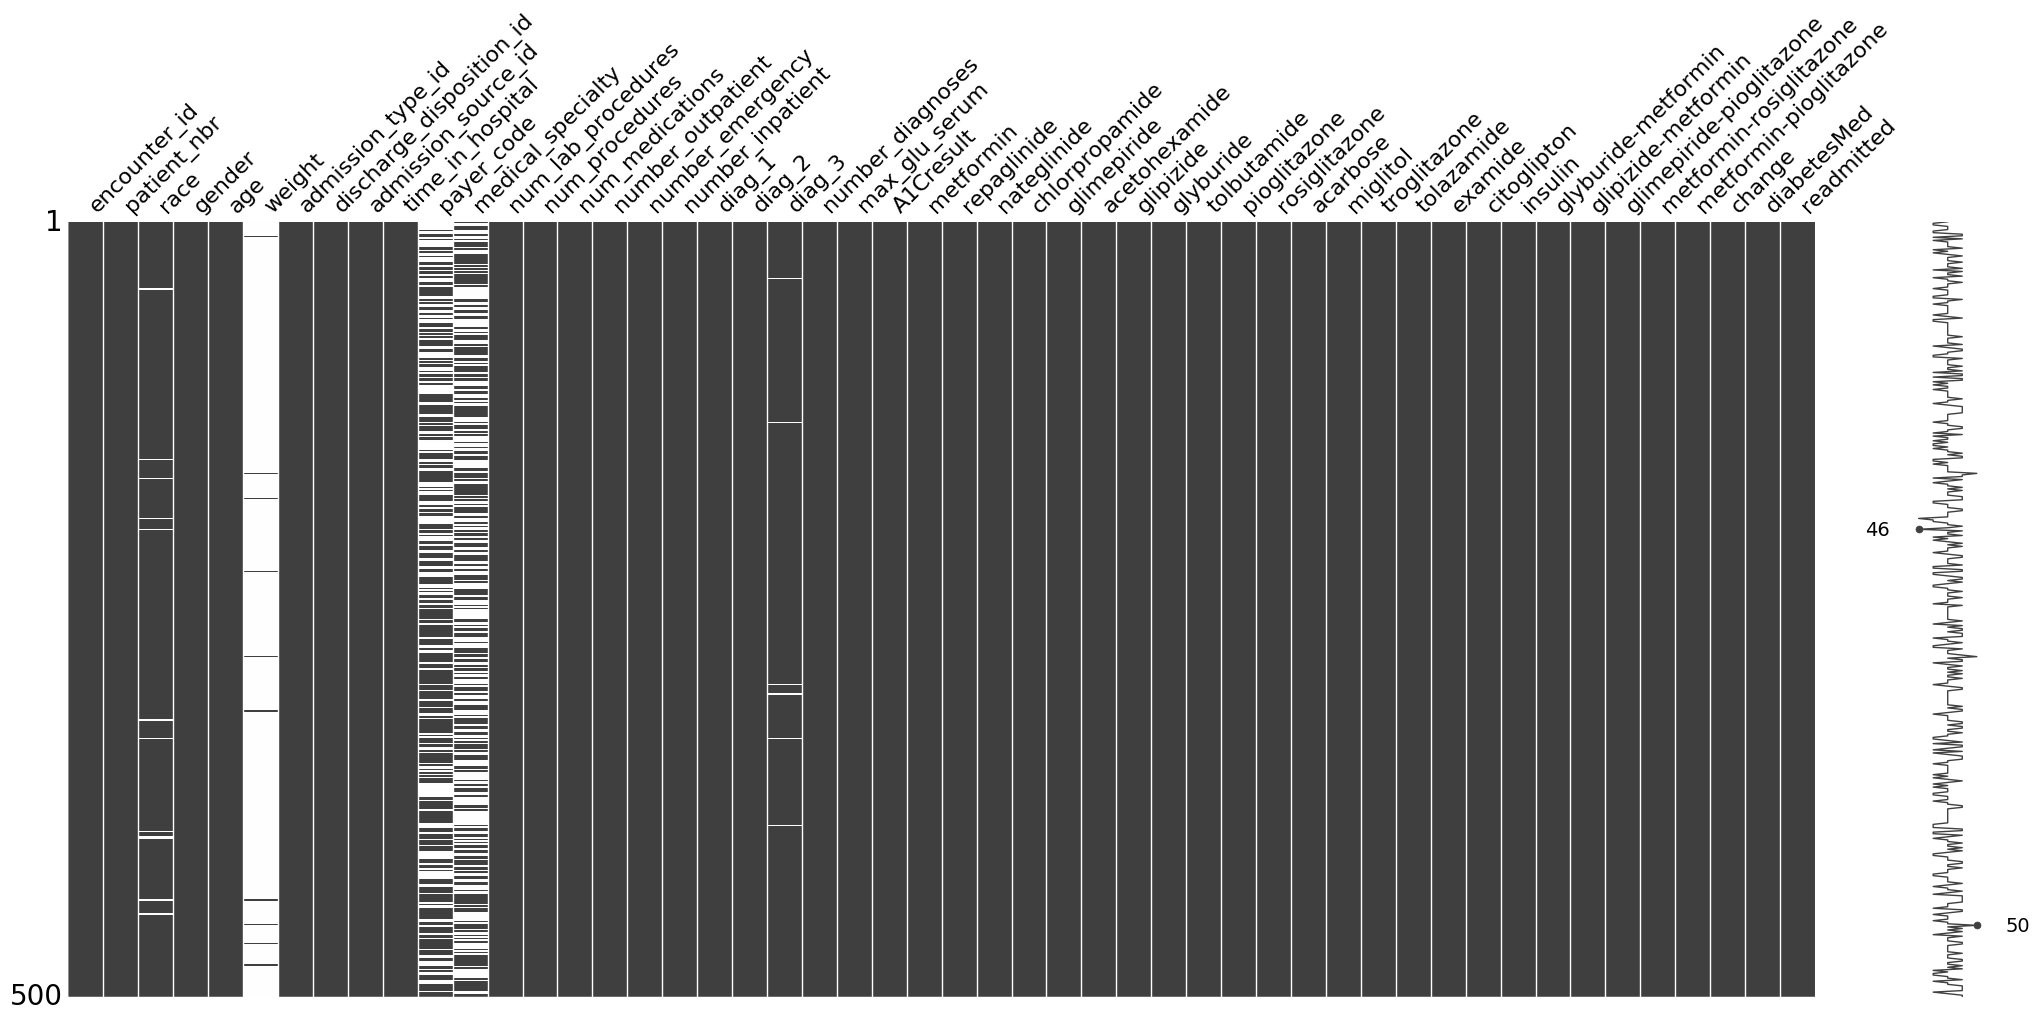

In [53]:
import missingno as msno
%matplotlib inline
msno.matrix(df.sample(500))

In [44]:
print('Proportion of NA values in weight column:',
      df['weight'].isnull().sum()/len(df['weight']))
print('Proportion of NA values in medical_specialty column:',
      df['medical_specialty'].isnull().sum()/len(df['medical_specialty']))
print('Proportion of NA values in race column:',
      df['race'].isnull().sum()/len(df['race']))

Proportion of NA values in weight column: 0.968584792563
Proportion of NA values in medical_specialty column: 0.490822082031
Proportion of NA values in race column: 0.0223355541143


In [56]:
df.T.apply(lambda x: x.nunique(), axis=1)

encounter_id                101766
patient_nbr                  71518
race                             5
gender                           3
age                             10
weight                           9
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      17
medical_specialty               72
num_lab_procedures             118
num_procedures                   7
num_medications                 75
number_outpatient               39
number_emergency                33
number_inpatient                21
diag_1                         716
diag_2                         748
diag_3                         789
number_diagnoses                16
max_glu_serum                    4
A1Cresult                        4
metformin                        4
repaglinide                      4
nateglinide                      4
chlorpropamide                   4
glimepiride         

In [128]:
# generate visualization for categorical vars 

feature_freq = pd.DataFrame(columns=['feature', 'index', 'freq'])
features = df.columns.values[2:,]

for f in features:
    column = df.groupby(f)['encounter_id'].nunique()
    for i in range(column.shape[0]):
        row = [f,i,column[i]]

KeyError: 0

In [123]:
fe = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
for i in range(5):
    fe.loc[i] = [1,2,3]
fe

,lib,qty1,qty2
0,1.0,2.0,3.0
1,1.0,2.0,3.0
2,1.0,2.0,3.0
3,1.0,2.0,3.0
4,1.0,2.0,3.0


In [111]:
column = df.groupby('readmitted')['encounter_id'].nunique()
column

readmitted
<30    11357
>30    35545
NO     54864
Name: encounter_id, dtype: int64

In [ ]:
# pt 3: remove columns that are 1) unique ids or 2) have the same value for all patients
features_removed = ['weight', 'examide', 'citoglipton',
                   'glimepiride-pioglitazone', 'metformin-pioglitazone', 
                    'acetohexamide', 'metformin-rosiglitazone', 'troglitazone']

df.drop(features_removed, axis = 1, inplace = True)

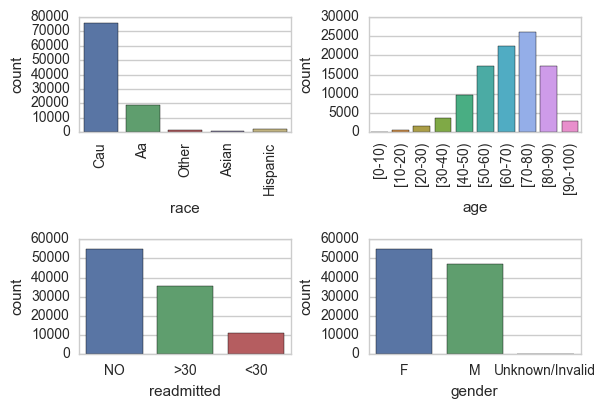

In [87]:
sns.set(style="whitegrid")
plt.subplot(2,2,1)
ax = sns.countplot(x="race", data=df)
plt.xlabel('race')
plt.xticks(rotation=90)
plt.subplot(2,2,2)
ax = sns.countplot(x="age", data=df)
plt.xticks(rotation=90)
plt.subplot(2,2,3)
ax = sns.countplot(x="readmitted", data=df)
plt.subplot(2,2,4)
ax = sns.countplot(x="gender", data=df)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [89]:
items = ['age', 'gender', 'race', 'max_glu_serum', 'A1Cresult', 'medical_specialty']
for i in items:
    pd.get_dummies(X, prefix=[i], columns=[i])
    X.drop([i], axis = 1, inplace = True)

X.drop(['diag_1'], axis = 1, inplace = True)
X.drop(['diag_2'], axis = 1, inplace = True)
X.drop(['diag_3'], axis = 1, inplace = True)

In [90]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

test_error = []
training_error = []

depth = list(range(1,60))

for i in depth:
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    training_error.append(1-clf.score(X_train, y_train))
    test_error.append(1-clf.score(X_test, y_test))

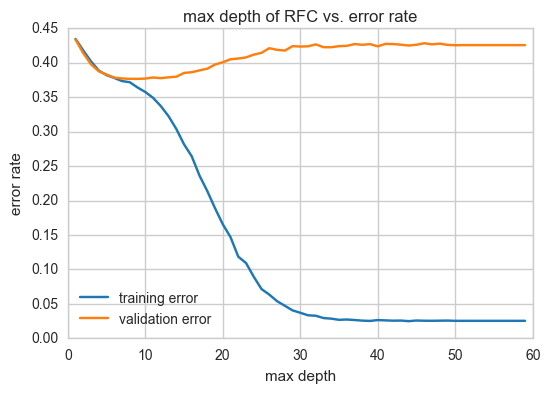

In [91]:
plt.plot(depth, training_error, color='#1f77b4', label="training error")
plt.plot(depth, test_error, color='#ff7f0e', label="validation error")
plt.xlabel('max depth')
plt.ylabel('error rate')
plt.title('max depth of RFC vs. error rate')
plt.legend(loc="best")
plt.show()

In [92]:
clf = RandomForestClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)
print('Training accuracy', clf.score(X_train, y_train))
print('Test accuracy', clf.score(X_test, y_test))

Training accuracy 0.63586231172
Test accuracy 0.62338087723


In [93]:
clf = RandomForestClassifier(max_depth=9, random_state=42)
score = cross_val_score(clf, X, y, cv=10)
score.mean()

0.61798651434640317

Random Forest score after formatting data but before feature selection/feature engineering is 62.4%. 

In [94]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train) 
knn.score(X_test, y_test)

0.56486913021469198

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, GridSearchCV

split = ShuffleSplit(n_splits=5,test_size=.33,random_state=42)

c = np.arange(-6,2)
c_val = 10.**c

parameters = {'C': c_val}

search = GridSearchCV(LogisticRegression(penalty='l2'), parameters, cv=split)
search.fit(X, y)

print('Best params:', search.best_params_)
print('Best score:', search.best_score_)

# l1 = LogisticRegression(penalty='l1',C=1)
# l1.fit(X_train, y_train)
# #l1.coef_
# l1.score(X_test, y_test)


Best params: {'C': 1.0}
Best score: 0.618026977935


In [1]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

3